# Лабораторная работа №5

Или записки сумашедшего. Коротко о том, что же можно написать нормального после ночей без сна...

Без прелюдий, сразу месиво


# Алгоритм имитации отжига

## Импорты


In [ ]:
!wget https://www.dropbox.com/s/8hh2fuyxga7rai8/cfp_data.zip?dl=0 -O cfp_data.zip
!unzip '/content/cfp_data.zip'

--2022-06-10 07:15:43--  https://www.dropbox.com/s/8hh2fuyxga7rai8/cfp_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8hh2fuyxga7rai8/cfp_data.zip [following]
--2022-06-10 07:15:44--  https://www.dropbox.com/s/raw/8hh2fuyxga7rai8/cfp_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7585a45ba2b8dcfb322a203192.dl.dropboxusercontent.com/cd/0/inline/Bm5YOinrkFxgZHtqUCsS5dmVgEH_pJgd84BKzK0fgkjDNL_eLtBN80p0WrqDMI8fhYNKJZsYZdBudBm9ZwZS6AT9JVrT_Lh2QOpmuzmkSCzNK9O4FmEYhRP-D99QjcnmRQSrECy4Q7eAKXTWMv5T_FfNPRh3QaiB_qCFq29wXbFq5w/file# [following]
--2022-06-10 07:15:44--  https://uc7585a45ba2b8dcfb322a203192.dl.dropboxusercontent.com/cd/0/inline/Bm5YOinrkFxgZHtqUCsS5dmVgEH_pJgd84BKzK0fgkjDNL_eLtBN80p0WrqD

In [ ]:
import random
import math
import numpy as np
import glob
from sklearn.cluster import KMeans
from copy import deepcopy
import os

## Данные

In [ ]:
directory_name = '/content/cfp_data'

In [ ]:
files = glob.glob(glob.escape(directory_name) + "/*.txt")

In [ ]:
data = []

for filepath in files:
  current_data = {}
  with open(filepath) as f:
    n, m = f.readline().split(' ')
    n, m = int(n), int(m)
    matrix = [[]]
    for line in range(n):
      
      new_line = f.readline()
      new_line = new_line.replace('\n', '').strip()
      new_line = new_line.split(' ')[1:]
      new_line_int = [int(x) for x in new_line]
      matrix.append(new_line_int)
    current_data['n'] = n
    current_data['m'] = m
    current_data['matrix'] = matrix
    file_name = os.path.basename(filepath)
    current_data['name'] = file_name
    data.append(current_data)

## Формируем нормальную матрицу

In [ ]:
def get_norm_matrix(matrix, m):
  new_matrix = [[0 for _ in range(m+1)] for j in range(len(matrix))]
  for i in range(1, len(matrix)):
    for el in matrix[i]:
      new_matrix[i][el] = 1
  return new_matrix

## Генерируем начальное решение:

In [ ]:
def generate_first_solution(matrix, m, n_clusters):
  similarity_matrix = get_similarity_matrix(matrix, m)
  groups = parts_group(similarity_matrix, n_clusters)
  cells = asign_to_cells(groups, matrix, m)
  return cells, similarity_matrix

### Этап 1: Подзадача с деталями

In [ ]:
def score_similarity(a_ij, b_ij, c_ij): 
  S = 0
  S = a_ij / (a_ij + b_ij + c_ij)
  return S

In [ ]:
def get_similarity_matrix(matrix, m):
  similarity_matrix = [[-1 for i in range(m+1)] for _ in range(m+1)]
  a_ij = 0 # кол-во машин, которые обрабатывают детали i, j
  b_ij = 0 # кол-во машин, которые обрабатывают i, но не j
  c_ij = 0 # кол-во машин, которые обрабатывают j, но не i

  for i in range(1, m + 1):
    for j in range(i + 1, m + 1):
      for k in range(1, len(matrix)):
        a_ij += matrix[k][i] * matrix[k][j]

        if matrix[k][i] and not matrix[k][j]:
          b_ij += 1

        if matrix[k][j] and not matrix[k][i]:
          c_ij += 1
      similarity_matrix[i][j] = score_similarity(a_ij, b_ij, c_ij)
      similarity_matrix[j][i] = similarity_matrix[i][j]

  return similarity_matrix

Даже колабу плохо: 

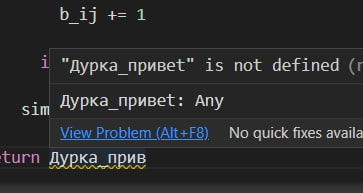

## K-**mem**:

xa-xa

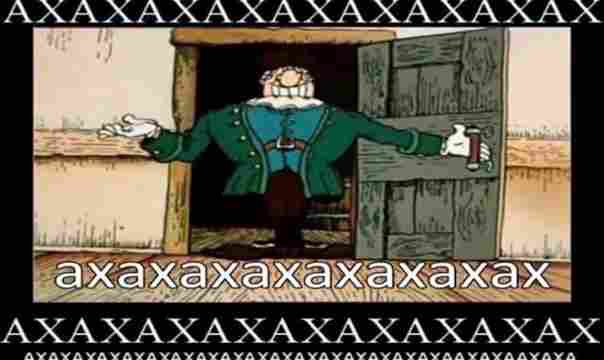

In [ ]:
def parts_group(similarity_matrix, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(similarity_matrix[1:])
  decision_maker = kmeans.labels_
  groups = [[] for i in range(n_clusters)]
  for i in range(1, len(similarity_matrix)):
    groups[decision_maker[i-1]].append(i)
  return groups

### Этап 2: Подзадача с станками:

In [ ]:
def asign_to_cells(groups, matrix, m):
  cells_decision = [[-1 for _ in range(len(groups))] for i in range(len(matrix))]
  cells = {i:[group,[]] for i, group in enumerate(groups)}

  for k, group in enumerate(groups):
    for i in range(1, len(matrix)):
      n_0_in = 0
      n_1_out = 0

      for j in range(1, m + 1):
        if j not in group and matrix[i][j]:
          n_1_out += 1
        if j in group and not matrix[i][j]:
          n_0_in += 1
      cells_decision[i][k] = n_1_out + n_0_in

  for i, machine in enumerate(cells_decision[1:]):
    ind_group = machine.index(min(machine))
    cells[ind_group][1].append(i + 1)
  
  return cells

## Считаем целевую функцию f

In [ ]:
def get_goal_func(matrix, cells, m):
  n_1 = sum([sum(i) for i in matrix])
  n_1_out = 0
  n_0_in = 0

  for _, value in cells.items():
    for machine_ind in value[1]:
      for j in range(1, m + 1):
        if j not in value[0] and matrix[machine_ind][j]:
          n_1_out += 1
        if j in value[0] and not matrix[machine_ind][j]:
          n_0_in += 1
  
  f = (n_1 - n_1_out) / (n_1 + n_0_in)
  return f

## Рисуем красоту (или нет)

In [ ]:
def break_matrix(matrix, cells):
  new_matrix = deepcopy(matrix)
  index = 1
  for l in cells.values():
    cols = l[0]
    for col_ind in cols:
      for i in range(1, len(matrix)):
        new_matrix[i][index] = matrix[i][col_ind]
      index += 1

  index = 1
  for l in cells.values():
    rows = l[1]
    for row_ind in rows:
      for i in range(1, len(matrix[0])):
        new_matrix[index][i] = matrix[row_ind][i]
      index += 1
  
  return new_matrix

## Меняшки - поменяшки

### Simple-move

Перемещаем одну деталь из одного цеха в какой-то другой

In [ ]:
def single_move(cells):
  new_cells = deepcopy(cells) # гарантирует, что cells не меняются
  part_groups = new_cells.values()
  new_part_groups = []

  for parts in part_groups:
    new_part_groups.append(parts[0]) # достаем детали для каждого цеха

  ind_list = [i for i in range(len(new_part_groups)) if len(new_part_groups[i]) > 1]

  ind_from = random.choice(ind_list)
  ind_to = random.choice([i for i in range(len(new_part_groups)) if ind_from != i])
  el = random.choice(new_part_groups[ind_from]) # и элемент


  new_part_groups[ind_from].remove(el) # меняем
  new_part_groups[ind_to].append(el)

  return new_part_groups

In [ ]:
l = [1,2,3,4,5]
l[:3] + l[3 + 1:]

[1, 2, 3, 5]

In [ ]:
cells = {0: [[1,2], [3,4]], 1: [[0,5], [4,6]]}
single_move(cells)

[[1], [0, 5, 2]]

### Exchange-move

Свопаем две детали между двумя цехами

In [ ]:
def exchange_move(cells):
  new_cells = deepcopy(cells) # гарантирует, что cells не меняются
  part_groups = new_cells.values()
  new_part_groups = []

  for parts in part_groups:
    new_part_groups.append(parts[0]) # достаем детали для каждого цеха

  ind_list = [i for i in range(len(new_part_groups))]

  ind_from, ind_to = random.sample(ind_list, 2) # выбираем цеха обмена

  el_from = random.choice(new_part_groups[ind_from]) # выбираем элементы обмена
  el_to = random.choice(new_part_groups[ind_to])

  new_part_groups[ind_from].remove(el_from) # меняем
  new_part_groups[ind_to].append(el_from)
  new_part_groups[ind_to].remove(el_to)
  new_part_groups[ind_from].append(el_to)

  return new_part_groups

In [ ]:
cells = {0: [[1,2], [3,4]], 1: [[0,5], [4,6]]}
exchange_move(cells)

[[2, 5], [0, 1]]

А колаб продолжает подавать мне знаки: 

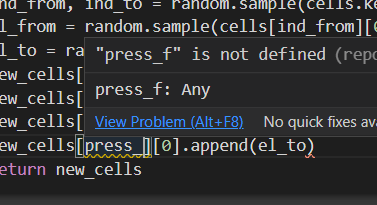

## Основной алгоритм

Итак, дабы не запутаться в переменных, сейчас будет жопа: 


1.   **counter** - общий счетчик всего алгоритма
2.   **counter_MC** - мах число решений
3.   **counter_trapped** - ограничение на кол-во непринятых плохих решений(?)
4.   **counter_stagnant** - сколько раз алгоритм может не улучшать решение
5.   **S** - текущее решение
6.   **S_c** - новое решение, полученное меняшками в данном распределении кластеров
7.   **S_opt_cell** - оптимальное решение для текущего числа кластеров
8.   **S_opt** - самое-самое оптимальное решение.
9.   **n_clusters** - текущее кол-во кластеров
10.  **C_opt** - оптимальное кол-во кластеров



In [ ]:
def get_solution(similarity_matrix, matrix, m, n_clusters):
  groups = parts_group(similarity_matrix, n_clusters)
  cells = asign_to_cells(groups, matrix, m)
  return cells

In [ ]:
def simulated_annealing(n, m, matrix, n_clusters):
  # обрабатываем данные
  matrix = get_norm_matrix(matrix, m)

  # генерируем первое решение
  C_opt = n_clusters
  S, similarity_matrix = generate_first_solution(matrix, m, n_clusters)
  S_opt_cell = deepcopy(S)
  S_opt = deepcopy(S)
  # print(matrix)

  init_flag = True
  counter = 0

  while counter < 20000:
    # инициализируем переменные
    if init_flag:
      T_0, T_f = 0.95, 0.002
      T = T_0
      L = 1000
      D = 3
      max_stagnant = 10
      counter, counter_MC, counter_trapped, counter_stagnant = 0, 0, 0, 0

      if n_clusters > 2:
        S = get_solution(similarity_matrix, matrix, m, n_clusters)

    while (counter_MC < L and counter_trapped < L/2):
      if counter % D == 0: # ??? что за counter здесь?
        new_groups_p = exchange_move(S)
      else:
        new_groups_p = single_move(S)

      S_c = asign_to_cells(new_groups_p, matrix, m)

      # проверочки
      f_opt_cell = get_goal_func(matrix, S_opt_cell, m)
      f_S_c = get_goal_func(matrix, S_c, m)

      # если найденное решение лучше оптимального на данном кол-ве кластеров
      if f_S_c > f_opt_cell: 
        S_opt_cell = deepcopy(S_c)
        S = deepcopy(S_c)
        counter_stagnant = 0
        counter_MC += 1
        continue

      # если найденное решение равно оптимальному на данном кол-ве кластеров
      if f_S_c == f_opt_cell: 
        S = deepcopy(S_c)
        counter_stagnant += 1
        counter_MC += 1
        continue

      # если найденное решение хуже оптимального на данном кол-ве кластеров
      f_S = get_goal_func(matrix, S, m)
      delta = f_S_c - f_S
      X = np.random.uniform(0, 1)
      if math.exp(delta / T) > X:
        # print(math.exp(delta / T), delta, T)
        S = deepcopy(S_c)
        counter_trapped = 0
      else:
        counter_trapped += 1
      
      counter_MC += 1
    
    # проверочки после while (внутренний)
    if T <= T_f or counter_stagnant > max_stagnant:
      f_opt_cell = get_goal_func(matrix, S_opt_cell, m)
      f_opt = get_goal_func(matrix, S_opt, m)

      # проверяем на то, найдено ли решение лучше, чем в S_opt
      if f_opt_cell > f_opt:
        S_opt = deepcopy(S_opt_cell)
        C_opt = n_clusters
        n_clusters += 1
        # print(f_opt_cell)
        # go to инициализация
        init_flag = True
      else:
        return S_opt # конец работы алгоритма

    else:
      alpha = np.random.uniform(0.7, 0.95)
      T = alpha * T
      counter_MC = 0
      counter += 1
      # go to while (how to do it?)
      init_flag = False

## Тестируем, красиво

In [ ]:
data[0]

{'m': 50,
 'matrix': [[],
  [8, 9, 21, 34, 43],
  [17, 19, 20, 38, 46],
  [1, 4, 16, 34, 39, 49],
  [17, 22, 32, 33, 34, 43],
  [2, 3, 11],
  [2, 17, 22, 39, 48],
  [19, 28, 29, 30, 41],
  [1, 4, 29, 33, 42, 45],
  [8, 21, 22, 36, 41, 49],
  [2, 3, 23, 24, 37, 39, 46, 47],
  [8, 9, 23, 25, 36, 41],
  [19, 20, 23, 24, 25, 44],
  [2, 3, 8, 9, 11, 40, 44],
  [19, 20, 31, 32, 44, 48],
  [10, 12, 18, 40, 46, 50],
  [21, 31, 32, 35, 39],
  [5, 7, 12, 28, 30, 37, 44, 50],
  [5, 6, 26, 27],
  [1, 21, 26, 28, 30, 43, 46, 47, 50],
  [5, 6, 7, 12, 26, 27, 29],
  [5, 7, 14, 35, 39, 45],
  [13, 15],
  [6, 21, 31, 34, 39, 46],
  [13, 15, 34, 41],
  [1, 4, 16, 33, 36, 40, 45],
  [10, 13, 17, 20, 31, 34, 35],
  [13, 15, 34, 43],
  [10, 14, 18, 40, 45],
  [17, 23, 24, 25],
  [16, 35, 39]],
 'n': 30,
 'name': '30x50.txt'}

In [ ]:
from time import time

In [ ]:
tests_results = {}

In [ ]:
tests_results_2 = {}

In [ ]:
n_clusters_list = [8, 11, 5, 5, 13]

In [ ]:
for test_num in range(len(data)):
  print(test_num)
  start_time = time()
  cells = simulated_annealing(data[test_num]['n'], data[test_num]['m'], data[test_num]['matrix'], n_clusters_list[test_num])
  print(cells)
  end_time = time() - start_time
  result = get_goal_func(get_norm_matrix(data[test_num]['matrix'], data[test_num]['m']), cells, data[test_num]['m'])
  tests_results[data[test_num]['name']] = [result, end_time, cells]

0
{0: [[1, 45, 16, 40, 4, 10, 33, 18], [3, 8, 25, 28]], 1: [[17, 23, 22, 24], [4, 6, 29]], 2: [[13, 34, 15, 31], [22, 23, 24, 26, 27]], 3: [[11, 3, 2, 47, 37], [5, 10, 13]], 4: [[35, 14, 39, 7], [16, 21, 30]], 5: [[9, 36, 41, 21, 8, 49, 25, 43, 32], [1, 9, 11]], 6: [[19, 20, 44, 38, 46], [2, 12, 14]], 7: [[50, 30, 28, 12], [7, 15, 17, 19]], 8: [[27, 6, 26, 5, 42, 48, 29], [18, 20]]}
1
{0: [[11, 72, 41, 13, 84, 54, 25, 12, 5, 31, 78, 79, 29, 70, 61, 28, 74, 62, 27, 36, 37, 60, 55, 34, 58], [26, 27, 28]], 1: [[59], [1, 2, 6, 7, 8, 9, 13, 16, 23]], 2: [[24, 52, 46, 3, 44, 39, 53, 49, 1, 19, 38, 80, 7, 65, 30, 33, 8, 42, 68, 20, 14, 6, 75], []], 3: [[40, 76, 89, 88, 21, 22, 77, 73, 90, 51, 15, 82, 56, 64], [11, 17, 19, 21, 24]], 4: [[87, 67], [14]], 5: [[69, 23, 4, 43, 71, 16, 2], [4]], 6: [[45, 86], [12]], 7: [[81, 85, 83, 9], [3, 5, 15, 22, 25, 30]], 8: [[48, 17, 63, 10, 35, 50], [20]], 9: [[18, 26], [10, 18]], 10: [[47, 66, 32, 57], [29]]}
2
{0: [[40], [12, 36]], 1: [[7, 9, 12, 14, 24, 

### Названия файлов


1.   20 на 20
2.   30 на 50
3.   30 на 90
4.   37 на 53
5.   24 на 40 



### 2 варианта:

Разное назначение входного количества кластеров

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(tests_results, orient='index', columns=['Конечное значение целевой функции', 'Время выполнения', 'Цеха'])

,Конечное значение целевой функции,Время выполнения,Цеха
30x50.txt,0.428571,544.337146,"{0: [[1, 45, 16, 40, 4, 10, 33, 18], [3, 8, 25..."
30x90.txt,0.353887,917.575114,"{0: [[11, 72, 41, 13, 84, 54, 25, 12, 5, 31, 7..."
37x53.txt,0.585868,517.216064,"{0: [[40], [12, 36]], 1: [[7, 9, 12, 14, 24, 1..."
20x20.txt,0.431507,78.839130,"{0: [[9, 6, 16, 14, 10], [1, 4, 6, 7, 8, 9, 16..."
24x40.txt,0.441379,408.221310,"{0: [[32, 2, 25, 11], [7, 14, 20, 24]], 1: [[2..."


In [ ]:
pd.DataFrame.from_dict(tests_results_2, orient='index', columns=['Конечное значение целевой функции', 'Время выполнения', 'Цеха'])

,Конечное значение целевой функции,Время выполнения,Цеха
30x50.txt,0.480952,936.952413,"{0: [[19, 44, 20, 24, 25, 48, 23], [12, 14, 29..."
30x90.txt,0.401084,963.810319,"{0: [[86, 38], [4, 12]], 1: [[6], [2, 6, 8, 9,..."
37x53.txt,0.579606,461.948093,"{0: [[20], [2, 5, 6, 13, 34, 35, 36, 37]], 1: ..."
20x20.txt,0.432624,110.497912,"{0: [[6, 9, 16, 1, 7], [1, 4, 6, 7, 9, 18]], 1..."
24x40.txt,0.450000,568.788141,"{0: [[8, 11, 28], [4, 14]], 1: [[1, 7], [22]],..."


In [ ]:
tests_results_2

{'20x20.txt': [0.4326241134751773,
  110.49791216850281,
  {0: [[6, 9, 16, 1, 7], [1, 4, 6, 7, 9, 18]],
   1: [[14, 18, 4, 5, 11], [3, 8, 11, 12, 16, 17]],
   2: [[17, 10, 2, 13, 19, 15], [2, 10, 13, 14]],
   3: [[20], [19]],
   4: [[12], []],
   5: [[8, 3], [5, 15, 20]]}],
 '24x40.txt': [0.45,
  568.7881412506104,
  {0: [[8, 11, 28], [4, 14]],
   1: [[1, 7], [22]],
   2: [[20, 24], [10, 12]],
   3: [[27, 37], [15]],
   4: [[15, 23, 22], [3, 11]],
   5: [[30, 18, 38, 5, 4, 26], [6, 8, 18]],
   6: [[34], [24]],
   7: [[14, 40, 13], [2, 19]],
   8: [[36, 32, 21], [16, 23]],
   9: [[16], []],
   10: [[35, 12], [5, 13]],
   11: [[31, 17, 29, 19], [1, 17]],
   12: [[25, 2], [7, 20]],
   13: [[10, 9, 3], [21]],
   14: [[39, 33, 6], [9]]}],
 '30x50.txt': [0.48095238095238096,
  936.9524133205414,
  {0: [[19, 44, 20, 24, 25, 48, 23], [12, 14, 29]],
   1: [[17, 38, 22, 32, 43], [2, 4, 6]],
   2: [[35, 39, 31], [16, 21, 23, 26, 30]],
   3: [[28, 30, 50, 37, 47], [7, 17, 19]],
   4: [[18, 10, 40,

# Save solutions to files

In [ ]:
solutions = {'20x20.txt': [0.4326241134751773,
  110.49791216850281,
  {0: [[6, 9, 16, 1, 7], [1, 4, 6, 7, 9, 18]],
   1: [[14, 18, 4, 5, 11], [3, 8, 11, 12, 16, 17]],
   2: [[17, 10, 2, 13, 19, 15], [2, 10, 13, 14]],
   3: [[20], [19]],
   4: [[12], []],
   5: [[8, 3], [5, 15, 20]]}],
 '24x40.txt': [0.45,
  568.7881412506104,
  {0: [[8, 11, 28], [4, 14]],
   1: [[1, 7], [22]],
   2: [[20, 24], [10, 12]],
   3: [[27, 37], [15]],
   4: [[15, 23, 22], [3, 11]],
   5: [[30, 18, 38, 5, 4, 26], [6, 8, 18]],
   6: [[34], [24]],
   7: [[14, 40, 13], [2, 19]],
   8: [[36, 32, 21], [16, 23]],
   9: [[16], []],
   10: [[35, 12], [5, 13]],
   11: [[31, 17, 29, 19], [1, 17]],
   12: [[25, 2], [7, 20]],
   13: [[10, 9, 3], [21]],
   14: [[39, 33, 6], [9]]}],
 '30x50.txt': [0.48095238095238096,
  936.9524133205414,
  {0: [[19, 44, 20, 24, 25, 48, 23], [12, 14, 29]],
   1: [[17, 38, 22, 32, 43], [2, 4, 6]],
   2: [[35, 39, 31], [16, 21, 23, 26, 30]],
   3: [[28, 30, 50, 37, 47], [7, 17, 19]],
   4: [[18, 10, 40, 46, 12], [15, 28]],
   5: [[15, 13, 34], [22, 24, 27]],
   6: [[1, 4, 45, 33, 16, 42, 49], [3, 8, 25]],
   7: [[27, 5, 26, 6, 7, 29, 14], [18, 20]],
   8: [[8, 9, 36, 21, 41], [1, 9, 11]],
   9: [[2, 3, 11], [5, 10, 13]]}],
 '30x90.txt': [0.4010840108401084,
  963.8103187084198,
  {0: [[86, 38], [4, 12]],
   1: [[6], [2, 6, 8, 9, 10, 13, 18, 23]],
   2: [[82, 52, 45, 67, 23, 75], [30]],
   3: [[59, 62], [14, 16]],
   4: [[36, 28, 11, 61, 10], [7, 25, 27]],
   5: [[87, 17, 78, 35, 34, 26, 18, 32], [20]],
   6: [[16, 39], [1]],
   7: [[37, 12, 30, 65], []],
   8: [[22, 21, 40, 76, 15, 88, 51, 64, 77, 56, 89, 68, 90, 73, 8, 63],
    [11, 17, 19, 21, 24]],
   9: [[47, 53, 20, 44, 80, 14], [29]],
   10: [[60,
     25,
     69,
     74,
     54,
     43,
     9,
     72,
     29,
     1,
     31,
     27,
     84,
     41,
     13,
     57,
     79,
     33,
     2,
     49,
     19,
     5,
     46,
     42,
     4,
     24,
     58,
     50,
     71,
     3,
     7,
     55,
     48,
     70,
     66],
    [26, 28]],
   11: [[85, 81, 83], [3, 5, 15, 22]]}],
 '37x53.txt': [0.5796064400715564,
  461.9480926990509,
  {0: [[20], [2, 5, 6, 13, 34, 35, 36, 37]],
   1: [[40], [12]],
   2: [[43,
     3,
     24,
     13,
     9,
     6,
     7,
     5,
     2,
     14,
     22,
     16,
     1,
     18,
     25,
     17,
     19,
     4,
     45,
     10,
     48,
     53,
     41,
     15,
     42,
     12,
     26,
     44,
     21,
     8,
     50,
     51,
     47,
     52,
     34,
     11,
     32,
     39,
     46,
     23,
     36,
     35,
     49,
     31,
     27],
    [4, 8, 10, 11, 14, 15, 17, 18, 19, 20, 21, 23, 26, 30, 31, 33]],
   3: [[38, 37, 28, 30, 33], [1, 3, 7, 9, 16, 22, 24, 25, 27, 28, 29, 32]],
   4: [[29], []]}]}

In [ ]:
for dataset_filename in solutions.keys():
  solution_dct = solutions[dataset_filename][2]
  machine_string = ''
  detail_string = ''
  num = 1
  found = True
  while found:
    found = False
    for key in solution_dct.keys():
      if num in solution_dct[key][0]:
        found = True
        detail_string += f' {key}'
        num += 1
        break

  num = 1
  found = True
  while found:
    found = False
    for key in solution_dct.keys():
      if num in solution_dct[key][1]:
        found = True
        machine_string += f' {key}'
        num += 1
        break

  dataset_key = dataset_filename.split('.')[0]
  with open(f'{dataset_key}.sol', 'w') as f:
    f.write(f'{machine_string}\n{detail_string}')

In [ ]:
from random import randint

In [ ]:
n = 100
k = 10
p = 100
i = randint(int(k * n/p) - 10, int(k * n/p))
j = randint(int((p-k) * n/p) + 1, int((p-k) * n/p) + 10)
print(i, j)

0 95
